In [1]:
"""Data Files"""
import glob
from IPython.display import clear_output
import torch.nn.functional as F
import torch.nn as nn
import torch
import pandas as pd

files_data = pd.read_csv('../../../../../ds004504/participants.tsv', sep="\t")

files = []
for file in glob.glob("../../../../../ds004504/derivatives/*/*/*.set"):
    files.append(file)

In [2]:
"""build data features and connectivity bands, 
Here the duration of each epoch is 30 sec and
the calculated connectivities"""
import numpy as np
import pickle

from read_data import build_data

SAVED_DATA = True

if SAVED_DATA:
    #with open('saved_files/all_boxcox_30.pkl', 'rb') as fp:
    #    all_boxcox = pickle.load(fp)
    with open('saved_files/all_X_bands_30.pkl', 'rb') as fp:
        all_X = pickle.load(fp)
    with open('saved_files/feat_30.pkl', 'rb') as fp:
        all_feat = pickle.load(fp)
    with open('saved_files/all_graphs_30.pkl', 'rb') as fp:
        all_graphs= pickle.load(fp)
    with open('saved_files/all_y_30.pkl', 'rb') as fp:
        all_y = pickle.load(fp)
    with open('saved_files/MMSE_30.pkl', 'rb') as fp:
        MMSE = pickle.load(fp)

else:
    all_X, all_graphs, all_y, ch_names = build_data(files, size=30, 
                                                files_data=files_data,
                                                cal_conn="all", 
                                                raw_eeg=True, 
                                                bands=True, 
                                                data_used="dem")
    all_feat = cal_features(all_X)
    MMSE = {}
    for file in files:
        MMSE[file] = get_MMSE(file)
    
    #all_boxcox = boxcox_dict(all_X, files)
    for k, v in all_X.items():
        all_X[k] = np.float16(v)
    for k, v in all_graphs.items():
        all_graphs[k] = np.float16(v) 
    #for k, v in all_boxcox.items():
    #    all_boxcox[k] = np.float16(v) 
    with open('saved_files/feat_30.pkl', 'wb') as fp:
        pickle.dump(all_feat, fp)
    with open('saved_files/all_X_bands_30.pkl', 'wb') as fp:
        pickle.dump(all_X, fp)
    with open('saved_files/all_graphs_30.pkl', 'wb') as fp:
        pickle.dump(all_graphs, fp)
    with open('saved_files/all_y_30.pkl', 'wb') as fp:
        pickle.dump(all_y, fp)
    with open('saved_files/MMSE_30.pkl', 'wb') as fp:
        pickle.dump(MMSE, fp)
clear_output()

In [4]:
from torch_geometric.nn import GATv2Conv, GeneralConv, GMMConv, GENConv, BatchNorm, global_mean_pool, TransformerConv, global_add_pool, GATConv, NNConv, ResGatedGraphConv, global_max_pool
from torch.nn import BatchNorm1d, BatchNorm2d
import torch.nn.functional as F
import torch.nn as nn
import torch
import numpy as np


class GATblock(nn.Module):
    def __init__(self, num_feat, nheads, hidden_dim, output_dim, num_edges):
        super(GATblock, self).__init__()
        self.nheads = nheads
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim 
        self.num_edges = num_edges
        
        self.conv1 = TransformerConv(num_feat, hidden_dim, heads=nheads,
                             edge_dim=num_edges)
        self.conv2 = TransformerConv(nheads*hidden_dim , output_dim , heads=nheads,
                                     edge_dim=num_edges)
        self.conv3 = TransformerConv(nheads*output_dim, output_dim, heads=nheads,
                             edge_dim=num_edges)
        
        self.BN1 = BatchNorm1d(19)
        self.BN2 = BatchNorm1d(19)
        self.BN3 = BatchNorm1d(19) 
    
    def forward(self, x, edge_index, edge_weigth):
        batch_size = int(x.shape[0]/19)
        x1 = self.conv1(x, edge_index, edge_weigth)
        x1 = x1.reshape(batch_size, 19, x1.shape[-1])
        x1 = F.leaky_relu(x1)
        x1 = self.BN1(x1)
        x1 = x1.reshape(batch_size*19, x1.shape[-1])
        x2 = self.conv2(x1, edge_index, edge_weigth)
        x2 = x1.reshape(batch_size, 19, x2.shape[-1])
        x2 = F.leaky_relu(x2)
        x2 = self.BN1(x2)
        x2 = x2.reshape(batch_size*19, x2.shape[-1])
        x3 = self.conv3(x2, edge_index, edge_weigth)
        x3 = x3.reshape(batch_size, 19, x3.shape[-1])
        x3 = F.leaky_relu(x3)
        x3 = self.BN1(x3)
        x3 = x3.reshape(batch_size*19, x3.shape[-1])
        return x1, x2, x3


class GraphModel1(nn.Module):
    def __init__(self, num_nodes, num_signals, num_conns, 
                 timepoints, num_edges, device):
        super(GraphModel1, self).__init__()
        self.GATout = 32
        self.GATin = 45
        self.GAThidden = 32
        self.num_signals = num_signals
        self.num_edges = num_edges
        self.num_nodes = num_nodes
        nheads = 5
        self.enc = GATblock(num_feat=self.GATin, nheads=nheads,
                            hidden_dim=self.GAThidden, output_dim=self.GATout, 
                            num_edges=num_edges).to(device)
        
        self.BN2 = BatchNorm(nheads*self.GATout*3)
        self.avgpool = nn.MaxPool2d(1, 3)
        self.fc1 = nn.Linear(nheads*self.GATout*3, 64)
       
    def forward(self, X, idx, attr, batch):
        #X = X[:, :, :]
        X = torch.flatten(X, start_dim=1)
        x1, x2, x3 = self.enc(X, idx, attr)
        output = torch.cat((x1, x2, x3), dim=-1) 
        output = global_max_pool(output, batch)
        output = self.BN2(output)
        output = self.fc1(output)
        return output


class OutputLayer(nn.Module):
    def __init__(self, num_feat, num_classes):
        super(OutputLayer, self).__init__()
        self.fc2 = nn.Linear(num_feat, num_classes)

    def forward(self, feat):
        out = F.dropout(F.relu(feat), training=self.training)
        out = self.fc2(out)
        return out


class ADGraph(nn.Module):
    def __init__(self, num_nodes, num_signals, num_edges, timepoints,
                 num_conns, num_out_feat, num_classes, device):
        super(ADGraph, self).__init__()
        self.outputlayer =  OutputLayer(num_out_feat, num_classes)
        self.num_edges = num_conns*num_signals
        self.device = device
        self.enc = GraphModel1(num_nodes=num_nodes, timepoints=timepoints,
                 num_signals=num_signals, num_conns=num_conns,
                 num_edges=self.num_edges, device=device)
        
    def forward(self, x, idx, attr, batch):
        out = self.enc(x, idx, attr, batch)
        out = self.outputlayer(out)
        return out

In [5]:
def predict(model, data_iter):
    ytrue = []
    ypreds = []
    
    model.eval()
    cn_threeshold = 0.5
    with torch.no_grad():
        for batch in data_iter:
            x, idx, attr, y, batch = batch.x, batch.edge_index, batch.edge_attr, batch.y, batch.batch
            x = x.float()
            attr = attr.float()
            idx = idx.long()
            yhat = model(x, idx, attr, batch)
            y = torch.argmax(y, dim=-1)
            y = y.detach().cpu().numpy()
            yhat = torch.argmax(yhat, dim=-1)
            yhat = yhat.detach().cpu().numpy()
            ytrue.extend([y_i for y_i in y])
            ypreds.extend([yhat_i for yhat_i in yhat])
    print(ypreds)
    len_ypreds = len(ypreds)
    
    non_pathological = 0
    pathological = 1
    
    pathological_count = ypreds.count(1) # count predict labels 1
    no_pathological_count = ypreds.count(0)
    if no_pathological_count >= cn_threeshold*len_ypreds: #if some pathological trails in subject
        ypreds = [non_pathological for _ in range(len_ypreds)]
    else:
        ypreds = [pathological for _ in range(len_ypreds)]
    
    return ytrue, ypreds

In [7]:
"""Reported accuracy of LOSO training (AD prediction)"""   

import torch, gc
from torch_geometric.loader import DataLoader
import random
from sklearn.model_selection import KFold    
from sklearn.preprocessing import OneHotEncoder

from utils import build_pyg_dl
from read_data import stack_arrays
from train import trainer, train_test_split_subjects#, predict
from evaluate import cal_accuracy, cal_accuracy_loso
from models.ADgraph import ADGraph


BATCH_SIZE = 100
NUM_EDGES = 15 # 3 connectivities X 5 frequency bands
NUM_CONNS= 3
NUM_CHANNELS= 19 # number of used EEG channels
DEVICE = "cpu" # if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 35 #35 with last model and 0.00001
TASK = "AD"
NUM_SIGNALS = 5
NUM_TIMEPOINTS = None
NUM_CLASSES = 2
NUM_OUT_FEAT = 64
SKIP_LABEL = 2 # 0:C, 1:AD, 2:FTD
SEED = 2025


all_val_acc = []
all_train_acc = []
kfold_num = 0
task_files = []
for file in files:
    if all_y[file][0] ==  1 or all_y[file][0] ==  0:
        task_files.append(file)


num_kfolds = int(len(task_files))
num_runs = num_kfolds

kf = KFold(n_splits=num_kfolds, shuffle=True, random_state=SEED)

all_cm = {}
AD_saved_models = []
AD_saved_iters = []

for train_idx, val_idx in kf.split(task_files):
    train_files = [task_files[i] for i in train_idx]
    val_files = [task_files[i] for i in val_idx]
    train_X2 = [all_feat[i] for i in train_files]
    val_X2 = [all_feat[i] for i in val_files]
    train_graphs = [all_graphs[i] for i in train_files]
    val_graphs = [all_graphs[i] for i in val_files]
    train_y = [all_y[i] for i in train_files]
    val_y = [all_y[i] for i in val_files]

    print("LOSO Subject:", val_files)
    
    # Stacks window arrays
    train_X, train_graphs, train_y = stack_arrays(train_X2, train_graphs, train_y, task=TASK)
    val_X, val_graphs, val_y = stack_arrays(val_X2, val_graphs, val_y, task=TASK)
    #train_X, val_X = std_feat(train_X, val_X)
    
    #ohe
    ohe = OneHotEncoder()
    train_y = ohe.fit_transform(train_y).toarray()
    val_y = ohe.transform(val_y).toarray()
    
    # build pyg dataloader
    train_dataset = [build_pyg_dl(x, g, y, NUM_EDGES, DEVICE) for x, g, y in zip(train_X, train_graphs, train_y)]
    val_dataset = [build_pyg_dl(x, g, y, NUM_EDGES, DEVICE) for x, g, y in zip(val_X, val_graphs, val_y)]
    train_iter = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_iter = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # create model
    torch.manual_seed(SEED)
    model = ADGraph(num_nodes=NUM_CHANNELS, 
                    num_out_feat=NUM_OUT_FEAT, 
                    num_classes=NUM_CLASSES, 
                    device=DEVICE, 
                    num_edges=NUM_EDGES, 
                    num_conns= NUM_CONNS,
                    timepoints=NUM_TIMEPOINTS, 
                    num_signals=NUM_SIGNALS).to(DEVICE)
    
    # training
    model, _, _ = trainer(NUM_EPOCHS, model, train_iter, val_iter, lr=0.00001)
    ytrue, ypreds = predict(model, val_iter)
    val_acc = cal_accuracy_loso(ytrue, ypreds)
    all_cm[val_files[0]] = val_acc[1]
    print("LOSO Accuracy: ", val_acc)
    AD_saved_models.append(model)
    AD_saved_iters.append(val_iter)
    del train_X
    del val_X

clear_output()

In [8]:
from evaluate import avg_accuracy
acc, sen, spec, prec, f1 = avg_accuracy(all_cm, all_y)
print("AD Prediction")
print("Accuracy:", acc)
print("Sensitivity:", sen)
print("Specificity:", spec)
print("Precision:", prec)
print("F1:", f1)

AD Prediction
Accuracy: 0.8112817483756645
Sensitivity: 0.8305177111716622
Specificity: 0.7885235332043843
Precision: 0.8228941684665226
F1: 0.8266883645240033


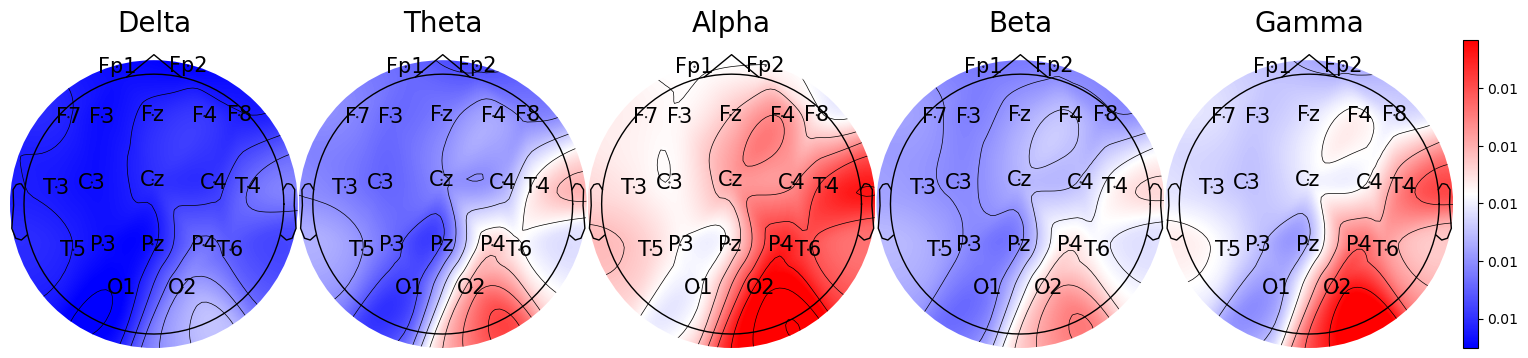

In [10]:
"""generate the feature saliency maps for the model using the test data"""

from explain import build_maps
import numpy as np
import matplotlib.pyplot as plt
from plot import plot_frequency_bands_graphs

all_node_imp = []
for x, model in zip(AD_saved_iters, AD_saved_models):
    model.eval()
    node_imp=build_maps(data_iter=x, map_kind="node", test_model=model)
    node_imp = np.array(node_imp)
    node_imp = node_imp.reshape(int(node_imp.shape[0]/19), 19, 9, 5)
    all_node_imp.append(node_imp)

node_imp = np.vstack(all_node_imp)
node_importances = np.mean(node_imp, axis=2)
node_importances = np.mean(node_importances, axis=0)
plot_frequency_bands_graphs(node_importances, "AD_avg_LOSO")
plt.show()

<Figure size 2000x400 with 0 Axes>

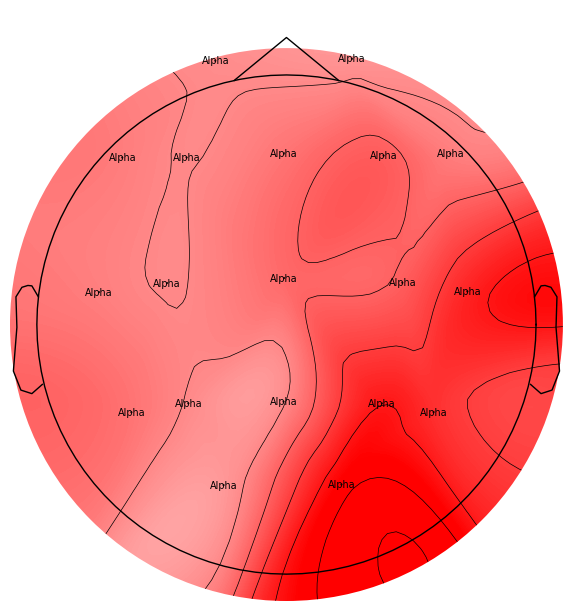

<Figure size 640x480 with 0 Axes>

In [11]:
"""better visuzualization of bands importances vs brain regions"""
import matplotlib.pyplot as plt
from plot import plot_bands_per_regions
node_imp_avg = np.mean(node_imp, 2)
node_imp_avg = np.mean(node_imp_avg, 0)
bands_names = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
maxs = np.argmax(node_imp_avg, -1)
maxm_means2bands = [bands_names[max_mean_band] for max_mean_band in maxs]
plot_bands_per_regions(node_imp_avg, maxm_means2bands, name="AD_band_region")
plt.show()

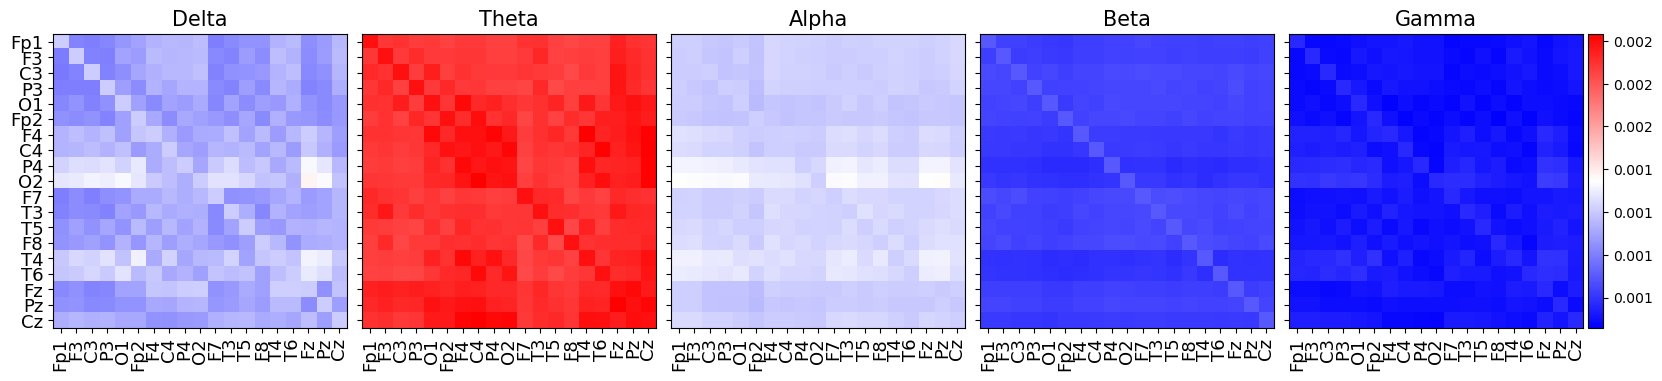

In [19]:
"""generate the feature saliency maps for the model using the test data"""
from utils import fill_diag
from plot import plot_edges

all_edge_imp = []
for x, model in zip(AD_saved_iters, AD_saved_models):
    model.eval()
    edge_imp=build_maps(data_iter=x, map_kind="edge", test_model=model)
    edge_imp = np.array(edge_imp)
    edge_imp = edge_imp.reshape(int(edge_imp.shape[0]/(19*19)), 19, 19, 5, 3)
    all_edge_imp.append(edge_imp)

edge_imp = np.vstack(all_edge_imp)

edge_importances = np.mean(edge_imp, axis=-1)
edge_importances = np.mean(edge_importances, axis=0)
edge_importances = np.moveaxis(edge_importances, -1, 0)
for edge in edge_importances:
    np.fill_diagonal(edge, np.mean(edge))
plot_edges(edge_importances, "AD_Overall")
plt.show()

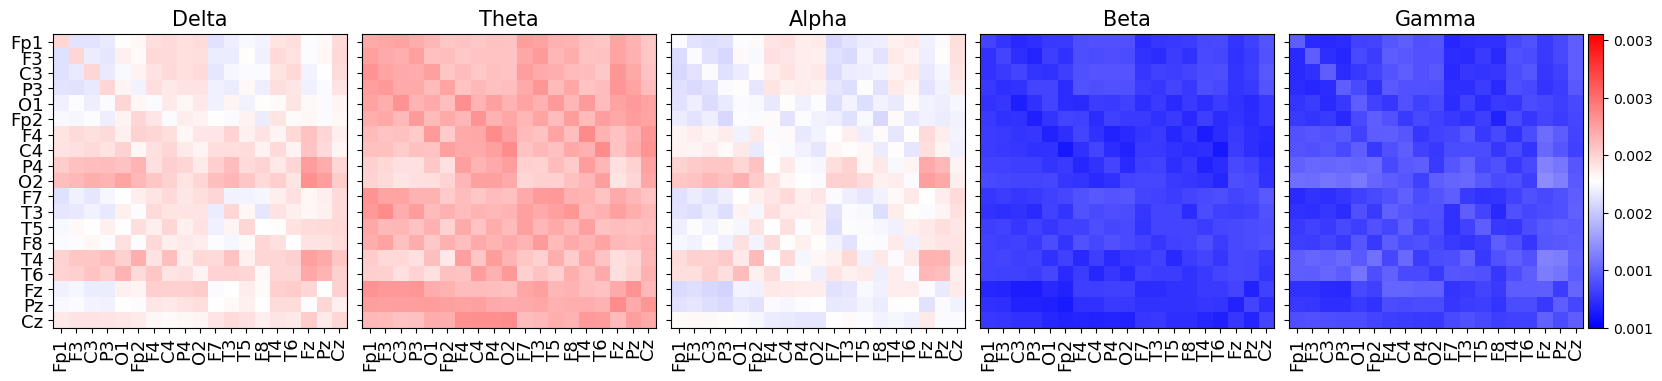

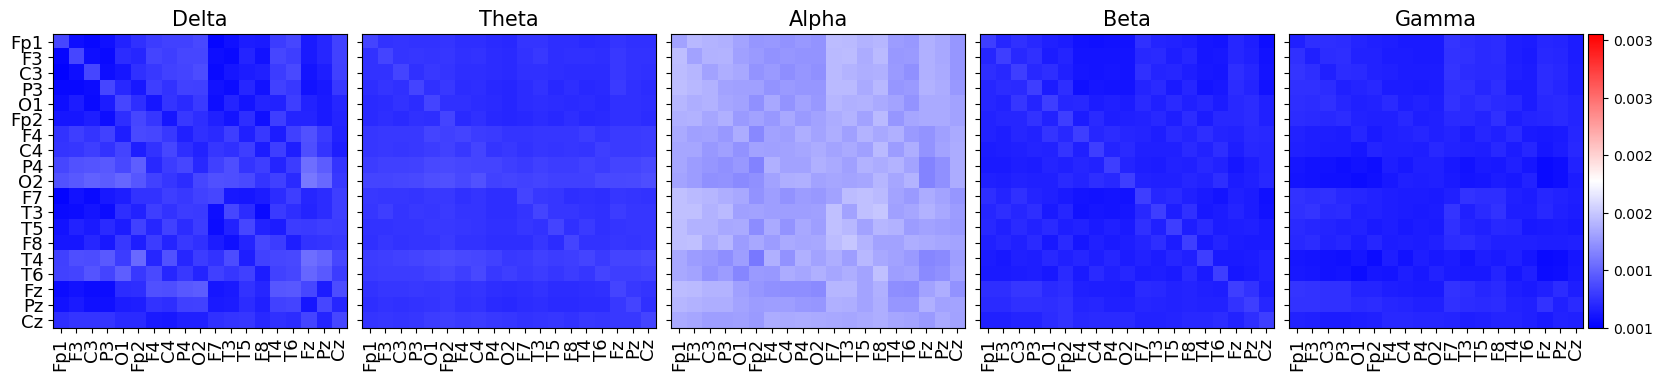

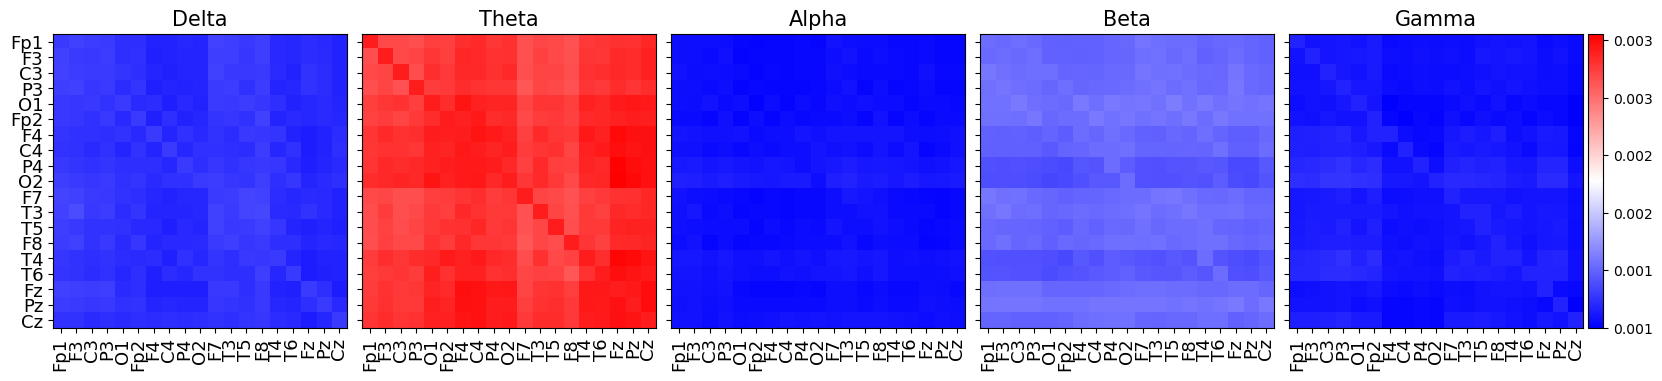

In [41]:
"""generate the feature saliency maps for the model using the test data"""
all_edge_imp = []
for x, model in zip(AD_saved_iters, AD_saved_models):
    model.eval()
    edge_imp=build_maps(data_iter=x, map_kind="edge", test_model=model)
    edge_imp = np.array(edge_imp)
    edge_imp = edge_imp.reshape(int(edge_imp.shape[0]/(19*19)), 19, 19, 5, 3)
    all_edge_imp.append(edge_imp)

edge_imp = np.vstack(all_edge_imp)
edge_imp = np.mean(edge_imp, axis=0)
for f_idx in range(edge_imp.shape[-1]):
    for band_idx in range(edge_imp.shape[-2]):
        np.fill_diagonal(edge_imp[:, :, band_idx, f_idx], np.mean(edge_imp[:, :, band_idx, f_idx]))
    
min_max = (np.min(edge_imp), np.max(edge_imp))

edge_importances_f = edge_imp[:, :, :, 0]
edge_importances = np.moveaxis(edge_importances_f, -1, 0)
plot_edges(edge_importances, "AD_coh", min_max)
plt.show()

edge_importances_f = edge_imp[:, :, :, 1]
edge_importances = np.moveaxis(edge_importances_f, -1, 0)
plot_edges(edge_importances, "AD_pli", min_max)
plt.show()

edge_importances_f = edge_imp[:, :, :, 2]
edge_importances = np.moveaxis(edge_importances_f, -1, 0)
plot_edges(edge_importances, "AD_plv", min_max)
plt.show()

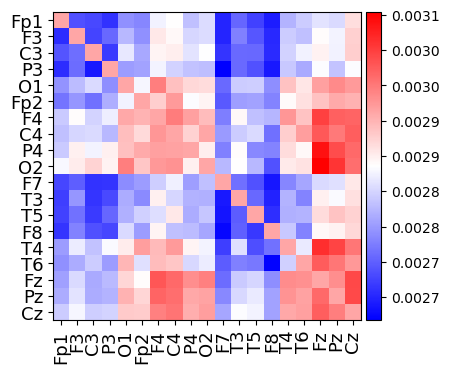

In [70]:
# show only plv plot in theta band
from plot import plot_single_edges
edge_importances_f = edge_imp[:, :, 1, 2]
edge_importances = edge_importances_f
plot_single_edges(edge_importances, "AD_plv_theta")
plt.show()

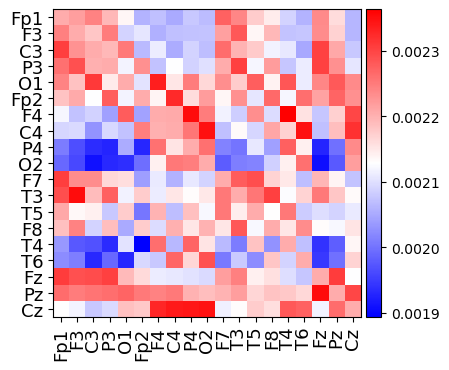

In [67]:
# show only coh plot in theta band
edge_importances_f = edge_imp[:, :, 1, 0]
edge_importances = edge_importances_f
plot_single_edges(edge_importances, "AD_coh_theta")

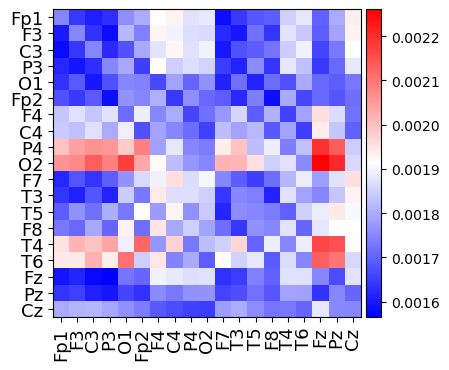

In [68]:
# show only coh plot in alpha band
edge_importances_f = edge_imp[:, :, 2, 0]
edge_importances = edge_importances_f
plot_single_edges(edge_importances, "AD_coh_alpha")

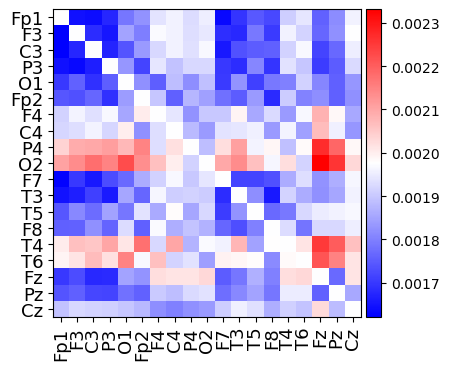

In [69]:
# show only coh plot in delta band
edge_importances_f = edge_imp[:, :, 0, 0]
edge_importances = edge_importances_f
plot_single_edges(edge_importances, "AD_coh_delta")

In [71]:
"""Test data size is 6 (AD prediction)"""   

NUM_TEST_SUBJECTS = 6
TASK = "FTD"
SKIP_LABEL = 2 # 0:C, 1:AD, 2:FTD
NUM_EPOCHS = 35 

task_files = []
for file in files:
    if all_y[file][0] ==  1 or all_y[file][0] ==  0:
        task_files.append(file)
        
num_kfolds = int(len(task_files)/NUM_TEST_SUBJECTS)
num_runs = num_kfolds

kf = KFold(n_splits=num_kfolds, shuffle=True, random_state=SEED)

all_cm = {}

for train_idx, val_idx in kf.split(task_files):
    train_files = [task_files[i] for i in train_idx]
    val_files = [task_files[i] for i in val_idx]
    train_X2 = [all_feat[i] for i in train_files]
    val_X2 = [all_feat[i] for i in val_files]
    train_graphs = [all_graphs[i] for i in train_files]
    val_graphs = [all_graphs[i] for i in val_files]
    train_y = [all_y[i] for i in train_files]
    val_y = [all_y[i] for i in val_files]

    print("KFolds Val Subject:", val_files)
    
    # Stacks window arrays
    train_X, train_graphs, train_y = stack_arrays(train_X2, train_graphs, train_y, task=TASK)
    val_X, val_graphs, val_y = stack_arrays(val_X2, val_graphs, val_y, task=TASK)
    
    #ohe
    ohe = OneHotEncoder()
    train_y = ohe.fit_transform(train_y).toarray()
    val_y = ohe.transform(val_y).toarray()
    
    # build pyg dataloader
    train_dataset = [build_pyg_dl(x, g, y, NUM_EDGES, DEVICE) for x, g, y in zip(train_X, train_graphs, train_y)]
    val_dataset = [build_pyg_dl(x, g, y, NUM_EDGES, DEVICE) for x, g, y in zip(val_X, val_graphs, val_y)]
    train_iter = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_iter = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # create model
    torch.manual_seed(SEED)
    model = ADGraph(num_nodes=NUM_CHANNELS, 
                 num_out_feat=NUM_OUT_FEAT, 
                 num_classes=NUM_CLASSES, 
                 device=DEVICE, 
                 num_edges=NUM_EDGES, 
                 num_conns= NUM_CONNS,
                 timepoints=NUM_TIMEPOINTS, 
                 num_signals=NUM_SIGNALS).to(DEVICE)

    # training
    model, _, _ = trainer(NUM_EPOCHS, model, train_iter, val_iter, lr=0.00001)

    # iterate over all val files and calculate LOSO accuracy
    for file in val_files:
        file = [file]
        val_X2 = [all_feat[i] for i in file]
        val_graphs = [all_graphs[i] for i in file]
        val_y = [all_y[i] for i in file]    

        val_X, val_graphs, val_y = stack_arrays(val_X2, val_graphs, val_y, task=TASK)
        val_y = ohe.transform(val_y).toarray()
        val_dataset = [build_pyg_dl(x, g, y, NUM_EDGES, DEVICE) for x, g, y in zip(val_X, val_graphs, val_y)]
        val_iter = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        ytrue, ypreds = predict(model, val_iter)
        val_acc = cal_accuracy_loso(ytrue, ypreds)
        all_cm[file[0]] = val_acc[1]
    
clear_output()

In [72]:
from evaluate import avg_accuracy
acc, sen, spec, prec, f1 = avg_accuracy(all_cm, all_y)
print("AD Prediction")
print("Accuracy:", acc)
print("Sensitivity:", sen)
print("Specificity:", spec)
print("Precision:", prec)
print("F1:", f1)

AD Prediction
Accuracy: 0.771116361488482
Sensitivity: 0.8169511477339612
Specificity: 0.7249555423829283
Precision: 0.7494600431965442
F1: 0.7817516192621796


In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Jan 30 07:34:26 2025

@author: mohamedr
"""

from captum.attr import Saliency, IntegratedGradients, GuidedGradCam, GuidedBackprop, ShapleyValueSampling, ShapleyValues
import torch

TEST_MODEL = None
def build_shap_maps(data_iter, map_kind, test_model):
    global TEST_MODEL

    masks = []
    for t, batch in enumerate(data_iter):
        x, idx, attr, y, batch = batch.x, batch.edge_index, batch.edge_attr, batch.y, batch.batch
        x = x.float()
        attr = attr.float()
        idx = idx.long()
        y = torch.argmax(y.int(), -1)
    
        if map_kind == "node":
            TEST_MODEL = test_model
            x.requires_grad=True
            attr.requires_grad=False
            sal = ShapleyValueSampling(model_forward1)
            mask = sal.attribute(x, target=y, additional_forward_args=(attr, idx, batch))
    
        elif map_kind == "edge":
            TEST_MODEL = test_model
            x.requires_grad=False
            attr.requires_grad=True
            sal = ShapleyValueSampling(model_forward2)
            mask = sal.attribute(attr, target=y, additional_forward_args=(x, idx, batch))
        
        mask = mask.squeeze().detach().numpy()
        masks.extend(mask)
    return masks

def model_forward1(X, attr, idx, batch):
    out = TEST_MODEL(X, idx, attr, batch)
    return out  

def model_forward2(attr, X, idx, batch): 
    out = TEST_MODEL(X, idx, attr, batch)
    return out

In [32]:
next(iter(val_iter))

DataBatch(x=[1007, 11, 5], edge_index=[2, 19133], edge_attr=[19133, 15], y=[53, 2], batch=[1007], ptr=[54])

In [16]:
all_node_imp = []
from tqdm import tqdm
for x, model in tqdm(zip(AD_test_iters, AD_saved_models)):
    model.eval()
    node_imp=build_shap_maps(data_iter=x, map_kind="node", test_model=model)
    node_imp = np.array(node_imp)
    all_node_imp.append(node_imp)

node_imp = np.vstack(all_node_imp)
#node_imp = np.mean(node_imp, 0)

65it [18:23, 16.98s/it]


In [22]:
feature_names = ["entropy_differential", "entropy_spectral", "complexity_hjorth", "entropy_power", "entropy_kl", 
                 "entropy_phase", "fractal_density", "Square PSD", "kurtosis", "mean", "std"]

In [18]:
node_imp.shape

(3386, 11, 5)

Average Feature Importances
entropy_differential :  0.159
entropy_spectral :  0.064
complexity_hjorth :  0.050
entropy_power :  0.081
entropy_kl :  0.056
entropy_phase :  0.092
fractal_density :  0.058
Square PSD :  0.116
kurtosis :  0.093
mean :  0.144
std :  0.038


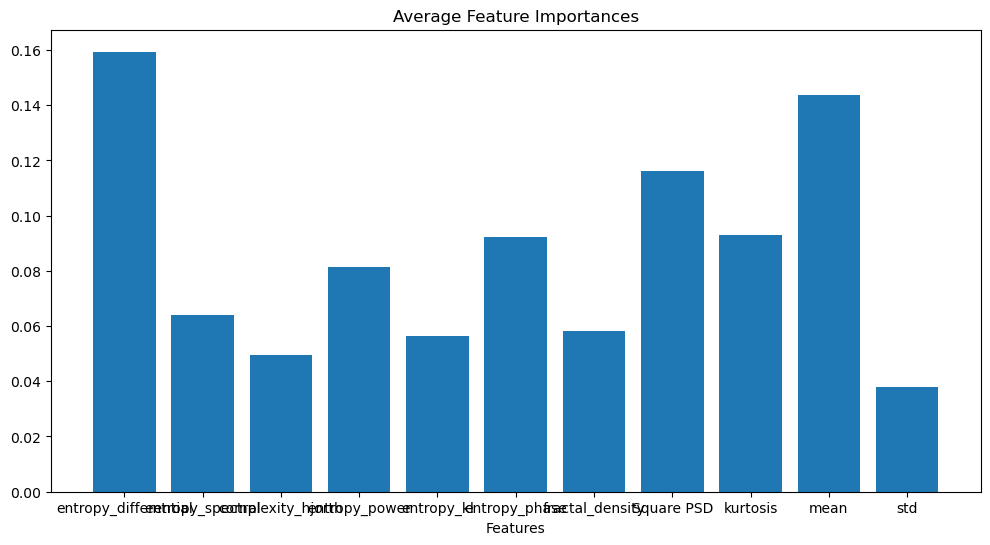

In [29]:
# Helper method to print importances and visualize distribution
import matplotlib.pyplot as plt
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
        
visualize_importances(feature_names, np.mean(node_imp[:, :, 0], axis=0))

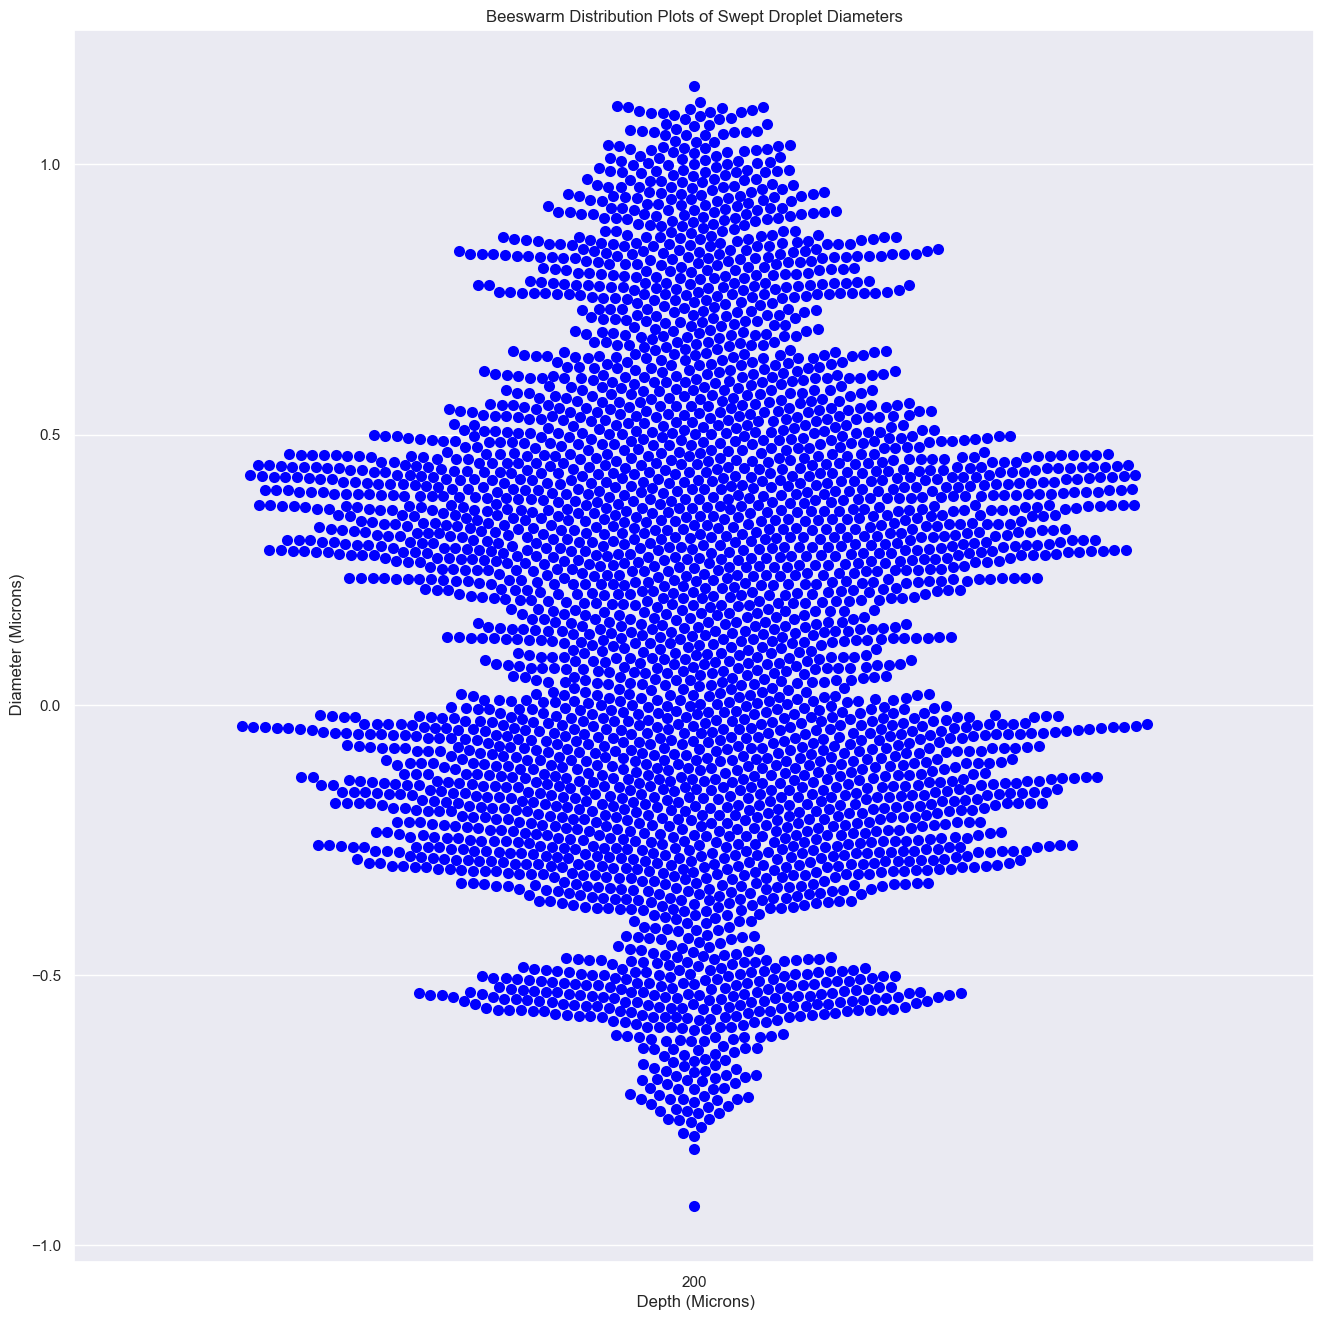

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn

x_labels = " Depth (Microns)"
y_labels = " Diameter (Microns)"

seaborn.set(color_codes=True)
fig = plt.figure(figsize=(16, 16))
 
# add title to plot
plt.title("Beeswarm Distribution Plots of Swept Droplet Diameters")
 
# plot data on swarmplot
seaborn.swarmplot(data=node_imp[:, 0, 0], color="blue", size=8)
 
# y-axis label
plt.ylabel(y_labels)
plt.xlabel(x_labels)
plt.xticks(labels=['200'], ticks=[0])

plt.show()

In [21]:
import shap
shap.plots.beeswarm(node_imp[:, :, 1], max_display=5, color="shap_red", show=False)


TypeError: The beeswarm plot requires an `Explanation` object as the `shap_values` argument.

In [114]:
feature_names = ["entropy_spectral", "complexity_hjorth", "entropy_power", "entropy_kl", 
                 "entropy_phase", "fractal_density", "Square PSD", "kurtosis", "mean", "std"]

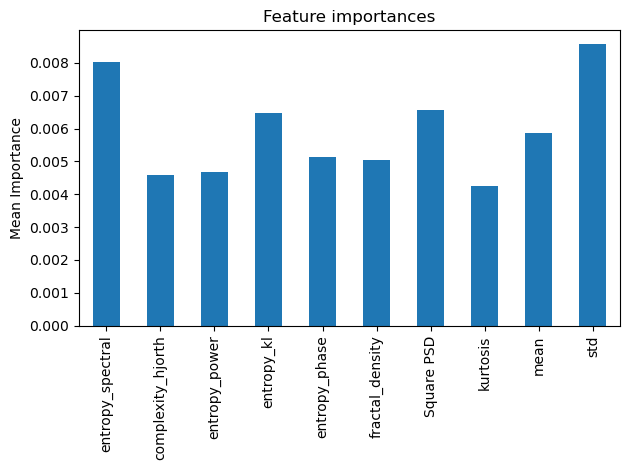

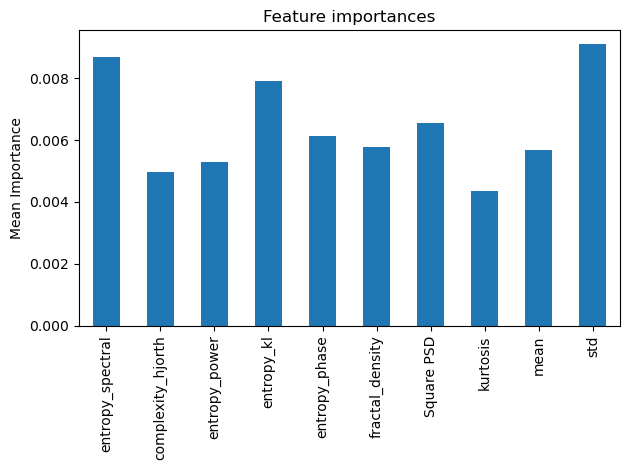

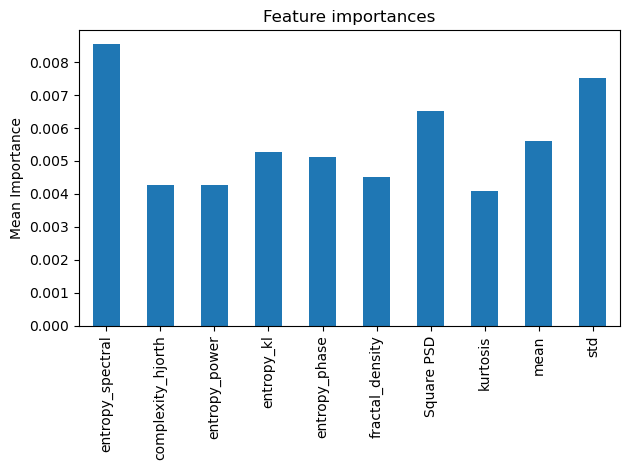

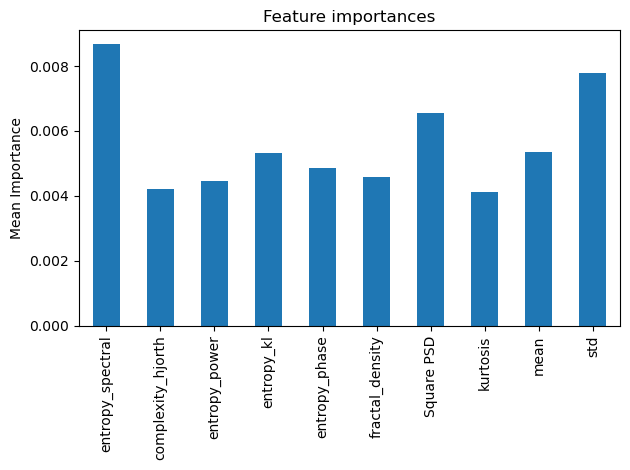

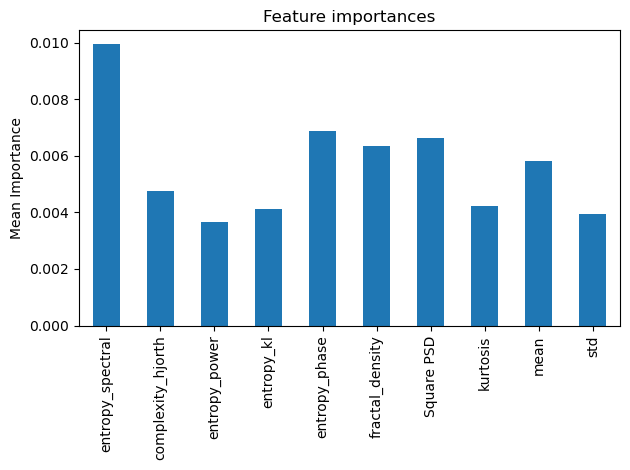

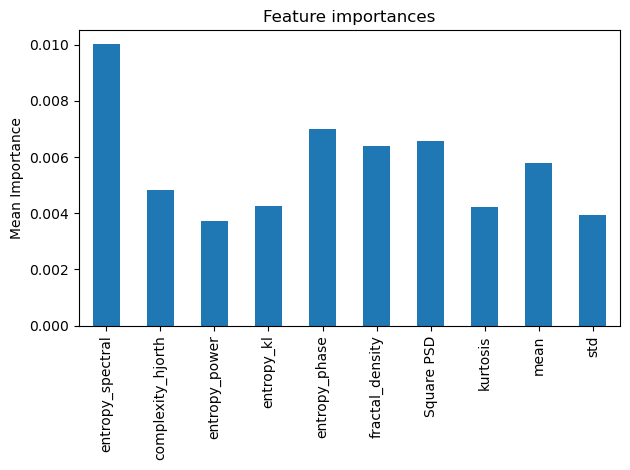

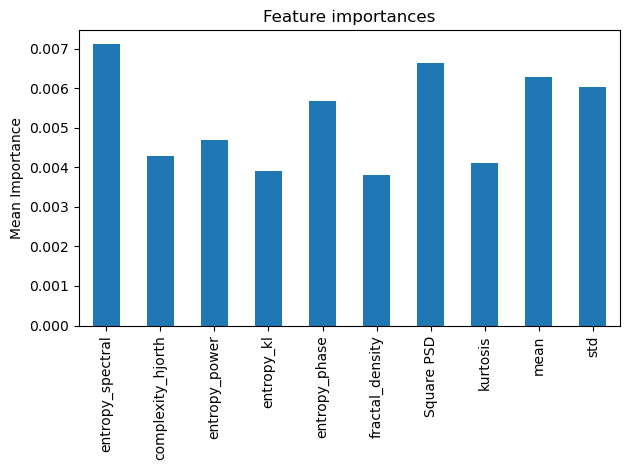

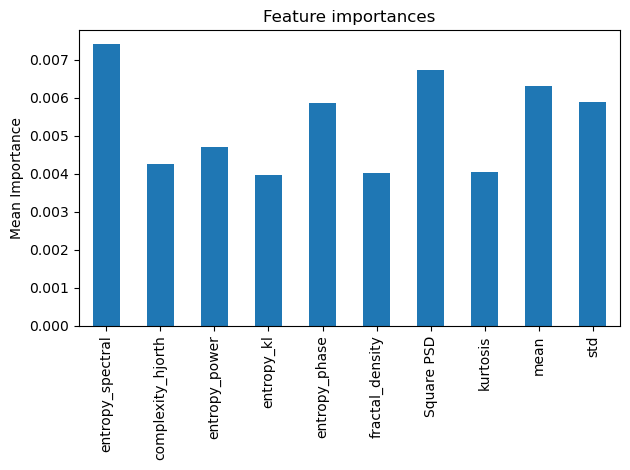

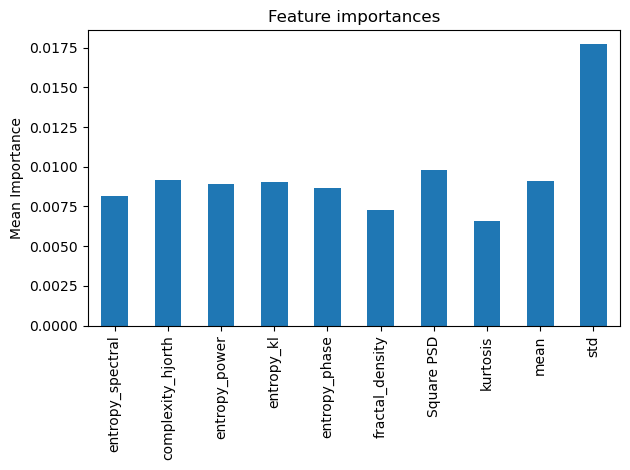

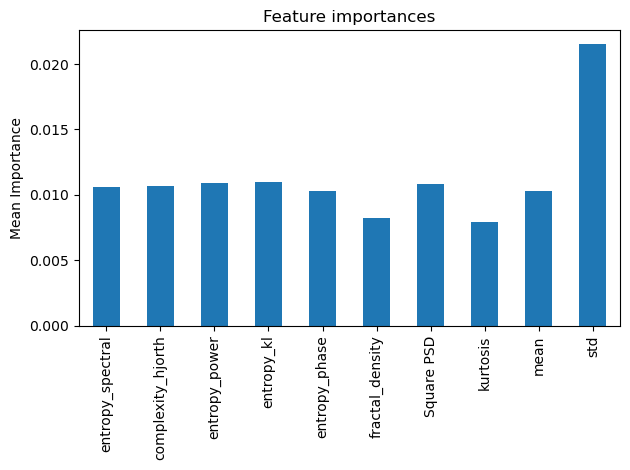

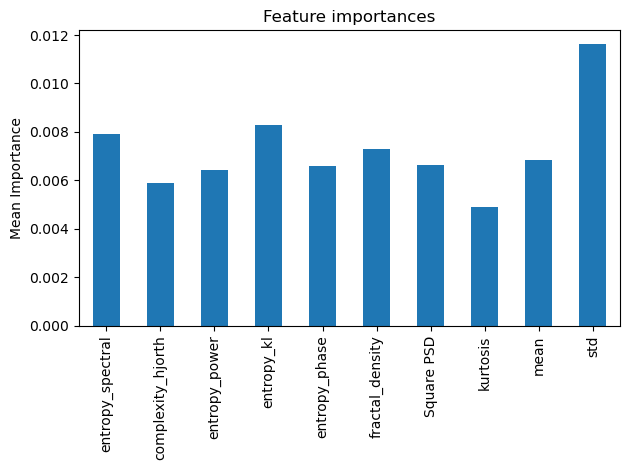

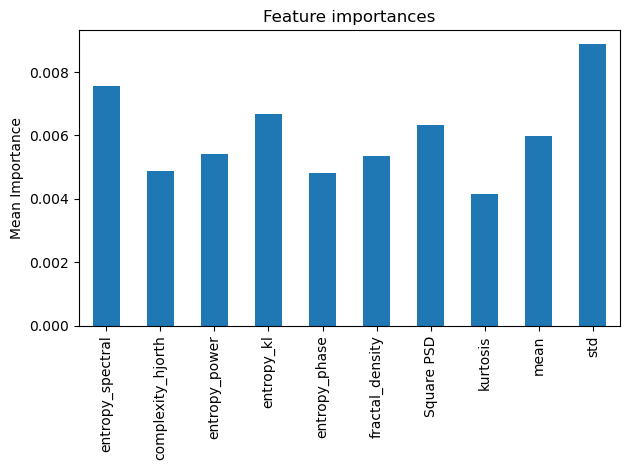

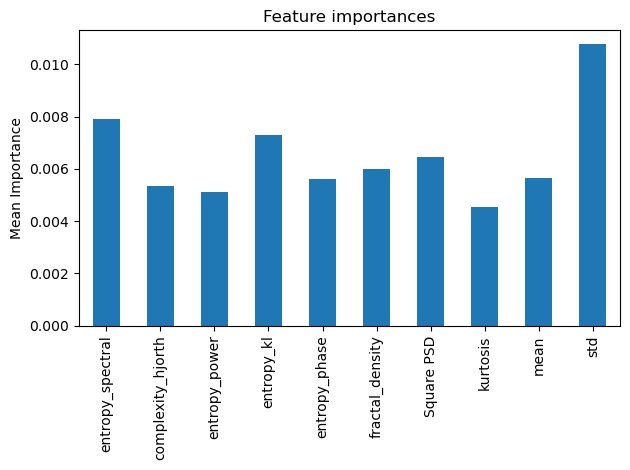

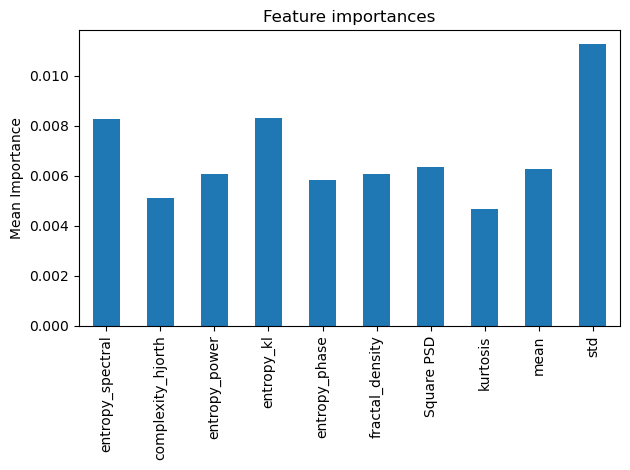

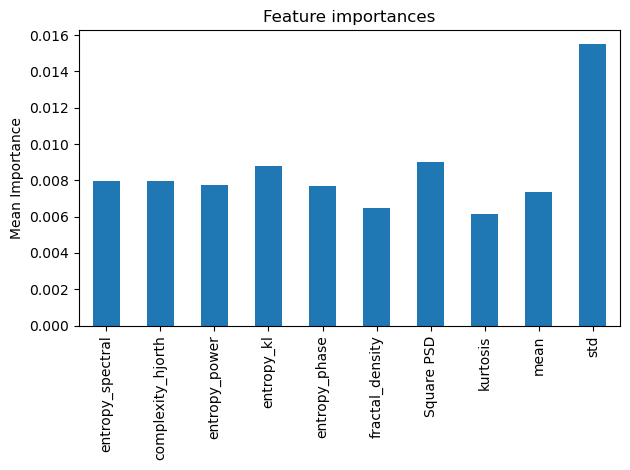

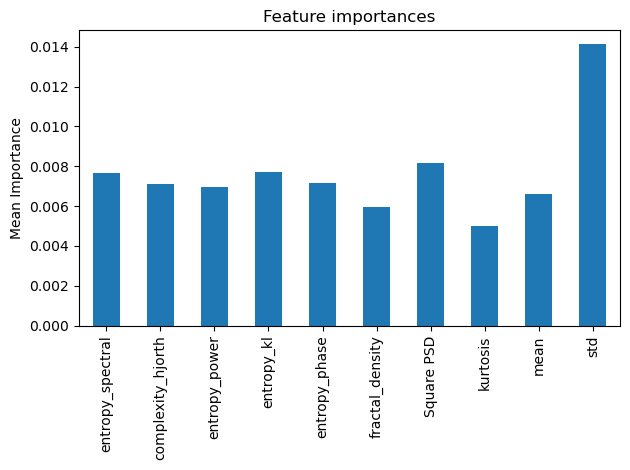

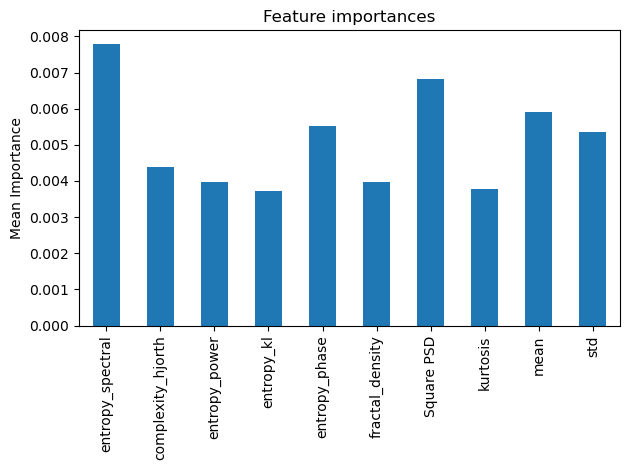

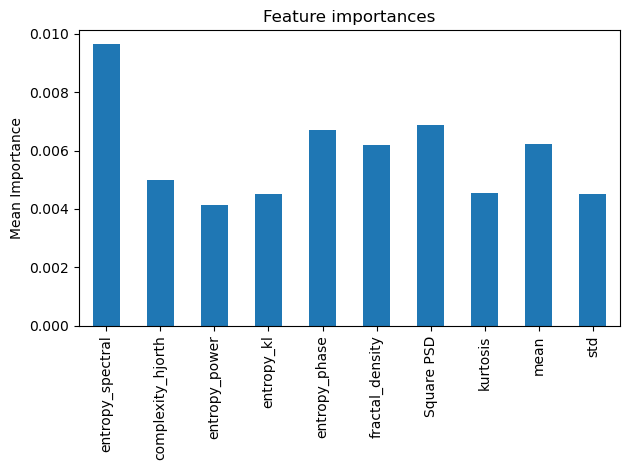

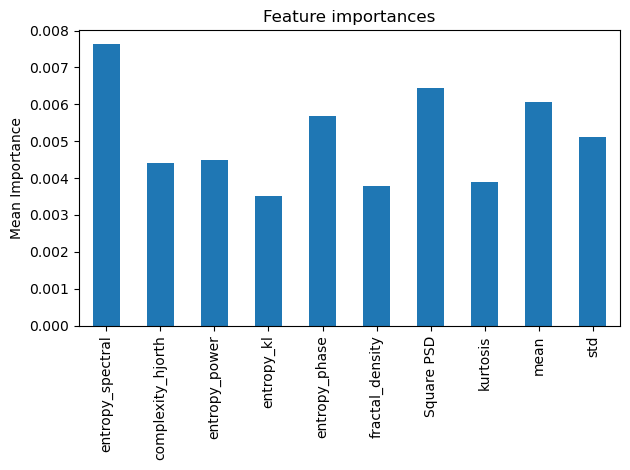

In [117]:
for i in range(19):
    forest_importances = pd.Series(node_imp[i, :, 0], index=feature_names)
    
    fig, ax = plt.subplots()
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances")
    ax.set_ylabel("Mean Importance")
    fig.tight_layout()
    plt.show()

/opt/anaconda3/envs/updated_env/lib/python3.10/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.


<Axes: >

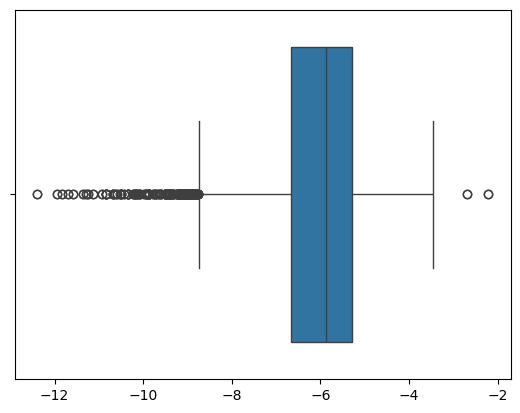

In [109]:
import seaborn as sns
data = np.log(node_imp[:, 4, :, -1])

sns.boxplot(x=data[:, 0])